# Statistical Arbitrage Trading Algorithm

This notebook implements a statistical arbitrage trading strategy for cryptocurrency pairs. It includes:
- Data ingestion from DeltaExchange API
- Ticker selection and trade quantity configuration
- Statistical arbitrage algorithm implementation
- Backtesting framework
- Trade signal generation and visualization
- Performance metrics calculation

## 1. Setup and Configuration

First, let's import the necessary libraries and set up our configuration parameters.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

### 1.1 Define Default Configuration Parameters

These parameters will be used as defaults but can be modified by the user later.

In [ ]:
# Default configuration parameters
config = {
    # Timeframe for data (in minutes)
    'timeframe': '1h',  # Options: '1m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '12h', '1d', '1w'

    # Lookback period for calculating moving averages and standard deviations
    'lookback_period': 30,  # in days

    # Z-score thresholds
    'entry_threshold': 1.1,  # Z-score threshold for trade entry
    'exit_threshold': 0.3,   # Z-score threshold for trailing exit
    'final_exit_threshold': 0.1,  # Z-score threshold for final forced exit
    'stop_loss_threshold': 3.1,  # Z-score threshold for stop loss

    # Trading parameters
    'trading_fee': 0.001,  # 0.1% trading fee
    'slippage': 0.001,     # 0.1% slippage

    # Backtesting date range (default: last 90 days)
    'start_date': (datetime.now() - timedelta(days=90)).strftime('%Y-%m-%d'),
    'end_date': datetime.now().strftime('%Y-%m-%d'),

    # DeltaExchange API base URL
    'api_base_url': 'https://api.india.delta.exchange'
}

# Display the configuration
pd.DataFrame(list(config.items()), columns=['Parameter', 'Value']).set_index('Parameter')

,Value
Parameter,
timeframe,1h
lookback_period,30
entry_threshold,1.1
exit_threshold,0.3
final_exit_threshold,0.1
stop_loss_threshold,3.1
trading_fee,0.001
slippage,0.001
start_date,2025-02-02


## 2. Ticker Selection and Trade Quantity Input

In this section, we'll create interactive widgets for users to select tickers, designate the primary asset, and specify the trade quantity.

### 2.1 DeltaExchange API Functions

First, let's implement functions to interact with the DeltaExchange API.

In [ ]:
def get_products():
    """
    Fetch available products (tickers) from DeltaExchange API.

    Returns:
        DataFrame: A DataFrame containing product information.
    """
    try:
        url = f"{config['api_base_url']}/v2/products"

        headers = {
            'Accept': 'application/json'
        }

        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors

        data = response.json()
        products = data.get('result', [])

        # Convert to DataFrame for easier filtering and display
        df_products = pd.DataFrame(products)

        # Filter for spot and perpetual futures products
        df_filtered = df_products[df_products['contract_type'].isin(['perpetual_futures'])]

        # Select relevant columns
        if not df_filtered.empty:
            columns = ['id', 'symbol', 'description', 'contract_type']
            df_filtered = df_filtered[columns]

        return df_filtered

    except Exception as e:
        print(f"Error fetching products: {e}")
        return pd.DataFrame()

def get_historical_candles(product_id, timeframe, start_time, end_time):
    """
    Fetch historical OHLC candle data for a specific product.

    Args:
        product_id (int): The product ID.
        timeframe (str): The timeframe for candles (e.g., '1h', '1d').
        start_time (int): Start time in Unix timestamp (seconds).
        end_time (int): End time in Unix timestamp (seconds).

    Returns:
        DataFrame: A DataFrame containing OHLC candle data.
    """
    try:
        # Get the product symbol from the product_id
        products_df = get_products()
        if products_df.empty:
            print("Error: Could not fetch products from DeltaExchange API")
            return pd.DataFrame()

        # Find the product symbol for the given product_id
        product_row = products_df[products_df['id'] == product_id]
        if product_row.empty:
            print(f"Error: Product ID {product_id} not found")
            return pd.DataFrame()

        symbol = product_row['symbol'].iloc[0]

        # Use the correct API endpoint for historical candles
        url = f"{config['api_base_url']}/v2/history/candles"

        headers = {
            'Accept': 'application/json'
        }

        params = {
            'resolution': timeframe,
            'symbol': symbol,
            'start': str(start_time),
            'end': str(end_time)
        }

        response = requests.get(url, params=params, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors

        data = response.json()
        candles = data.get('result', [])

        # Convert to DataFrame
        df_candles = pd.DataFrame(candles)

        if not df_candles.empty:
            # Rename columns to standard OHLC format
            df_candles = df_candles.rename(columns={
                'time': 'timestamp',
                'open': 'open',
                'high': 'high',
                'low': 'low',
                'close': 'close',
                'volume': 'volume'
            })

            # Convert timestamp to datetime
            df_candles['timestamp'] = pd.to_datetime(df_candles['timestamp'], unit='s')

            # Set timestamp as index
            df_candles = df_candles.set_index('timestamp')

            # Convert price columns to numeric
            for col in ['open', 'high', 'low', 'close', 'volume']:
                df_candles[col] = pd.to_numeric(df_candles[col])

            # Sort by timestamp
            df_candles = df_candles.sort_index()

        return df_candles

    except Exception as e:
        print(f"Error fetching historical candles: {e}")
        return pd.DataFrame()

In [ ]:
# Test the API functions
products_df = get_products()
if not products_df.empty:
    print(f"Successfully fetched {len(products_df)} products from DeltaExchange API")
    display(products_df.head())
else:
    print("Failed to fetch products from DeltaExchange API")

Successfully fetched 125 products from DeltaExchange API


,id,symbol,description,contract_type
737,68178,1000XUSD,1000X X Empire perpetual future quoted in USD,perpetual_futures
738,68177,API3USD,API3 perpetual future quoted in USD,perpetual_futures
739,68176,MUBARAKUSD,MUBARAK perpetual future quoted in USD,perpetual_futures
740,68175,BMTUSD,BMT perpetual future quoted in USD,perpetual_futures
741,67711,LAYERUSD,LAYER perpetual future quoted in USD,perpetual_futures


### 2.2 Interactive Ticker Selection and Trade Configuration

Now, let's create interactive widgets for users to select tickers, designate the primary asset, and specify the trade quantity.

In [ ]:
def create_ticker_selection_widgets():
    """
    Create interactive widgets for ticker selection and trade configuration.

    Returns:
        tuple: A tuple containing the widgets and a function to get the selected values.
    """
    # Get products for dropdown options
    products_df = get_products()

    if products_df.empty:
        print("Error: Could not fetch products from DeltaExchange API")
        return None, None

    # Create dropdown options
    dropdown_options = [(f"{row['symbol']} ({row['description']})", row['id']) for _, row in products_df.iterrows()]

    # Create widgets
    asset_a_dropdown = widgets.Dropdown(
        options=dropdown_options,
        description='Asset A:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='80%')
    )

    asset_b_dropdown = widgets.Dropdown(
        options=dropdown_options,
        description='Asset B:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='80%')
    )

    # Set default values to BTC and ETH if available
    btc_options = [opt for opt in dropdown_options if 'BTC' in opt[0] and 'USDT' in opt[0]]
    eth_options = [opt for opt in dropdown_options if 'ETH' in opt[0] and 'USDT' in opt[0]]

    if btc_options:
        asset_a_dropdown.value = btc_options[0][1]

    if eth_options:
        asset_b_dropdown.value = eth_options[0][1]

    # Primary asset selection
    primary_asset_radio = widgets.RadioButtons(
        options=['Asset A', 'Asset B'],
        value='Asset A',
        description='Primary Asset:',
        style={'description_width': 'initial'}
    )

    # Trade quantity input
    quantity_input = widgets.FloatText(
        value=1.0,
        description='Quantity:',
        min=0.0001,
        step=0.01,
        style={'description_width': 'initial'}
    )

    # Timeframe selection
    timeframe_dropdown = widgets.Dropdown(
        options=['1m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '12h', '1d', '1w'],
        value=config['timeframe'],
        description='Timeframe:',
        style={'description_width': 'initial'}
    )

    # Date range selection
    start_date_picker = widgets.DatePicker(
        description='Start Date:',
        value=pd.to_datetime(config['start_date']),
        style={'description_width': 'initial'}
    )

    end_date_picker = widgets.DatePicker(
        description='End Date:',
        value=pd.to_datetime(config['end_date']),
        style={'description_width': 'initial'}
    )

    # Function to get selected values
    def get_selected_values():
        # Get product details for the selected assets
        asset_a_details = products_df[products_df['id'] == asset_a_dropdown.value].iloc[0].to_dict()
        asset_b_details = products_df[products_df['id'] == asset_b_dropdown.value].iloc[0].to_dict()

        # Determine primary and secondary assets
        if primary_asset_radio.value == 'Asset A':
            primary_asset = asset_a_details
            secondary_asset = asset_b_details
        else:
            primary_asset = asset_b_details
            secondary_asset = asset_a_details

        # Convert dates to timestamps
        start_timestamp = int(pd.Timestamp(start_date_picker.value).timestamp())
        end_timestamp = int(pd.Timestamp(end_date_picker.value).timestamp())

        return {
            'asset_a': asset_a_details,
            'asset_b': asset_b_details,
            'primary_asset': primary_asset,
            'secondary_asset': secondary_asset,
            'quantity': quantity_input.value,
            'timeframe': timeframe_dropdown.value,
            'start_timestamp': start_timestamp,
            'end_timestamp': end_timestamp
        }

    # Create a button to confirm selection
    confirm_button = widgets.Button(
        description='Confirm Selection',
        button_style='success',
        icon='check'
    )

    output = widgets.Output()

    def on_confirm_button_clicked(b):
        with output:
            clear_output()
            selected = get_selected_values()
            print(f"Selected Configuration:")
            print(f"Asset A: {selected['asset_a']['symbol']} ({selected['asset_a']['description']})")
            print(f"Asset B: {selected['asset_b']['symbol']} ({selected['asset_b']['description']})")
            print(f"Primary Asset: {selected['primary_asset']['symbol']}")
            print(f"Quantity: {selected['quantity']}")
            print(f"Timeframe: {selected['timeframe']}")
            print(f"Date Range: {pd.to_datetime(selected['start_timestamp'], unit='s').strftime('%Y-%m-%d')} to {pd.to_datetime(selected['end_timestamp'], unit='s').strftime('%Y-%m-%d')}")

    confirm_button.on_click(on_confirm_button_clicked)

    # Organize widgets
    asset_selection = widgets.VBox([
        widgets.HTML(value="<h3>Asset Selection</h3>"),
        asset_a_dropdown,
        asset_b_dropdown,
        primary_asset_radio,
        quantity_input
    ])

    data_config = widgets.VBox([
        widgets.HTML(value="<h3>Data Configuration</h3>"),
        timeframe_dropdown,
        widgets.HBox([start_date_picker, end_date_picker])
    ])

    all_widgets = widgets.VBox([
        asset_selection,
        data_config,
        confirm_button,
        output
    ])

    return all_widgets, get_selected_values

# Create and display the widgets
ticker_widgets, get_ticker_config = create_ticker_selection_widgets()
if ticker_widgets:
    display(ticker_widgets)

## 3. Data Acquisition from DeltaExchange

Now that we have selected our tickers and configured our trade parameters, let's fetch the historical data for our selected assets.

Fetching historical data for BTCUSD and ETHUSD...
Successfully fetched data:
Asset A (BTCUSD): 2946 candles
Asset B (ETHUSD): 2946 candles
Merged data: 2946 rows


,close_a,log_price_a,symbol_a,close_b,log_price_b,symbol_b
timestamp,,,,,,
2025-05-03 13:00:00,96288.0,11.475099,BTCUSD,1834.45,7.514500,ETHUSD
2025-05-03 14:00:00,96314.5,11.475374,BTCUSD,1834.50,7.514527,ETHUSD
2025-05-03 15:00:00,96359.0,11.475836,BTCUSD,1833.95,7.514227,ETHUSD
2025-05-03 16:00:00,96150.5,11.473670,BTCUSD,1826.55,7.510184,ETHUSD
2025-05-03 17:00:00,95987.0,11.471968,BTCUSD,1818.45,7.505740,ETHUSD


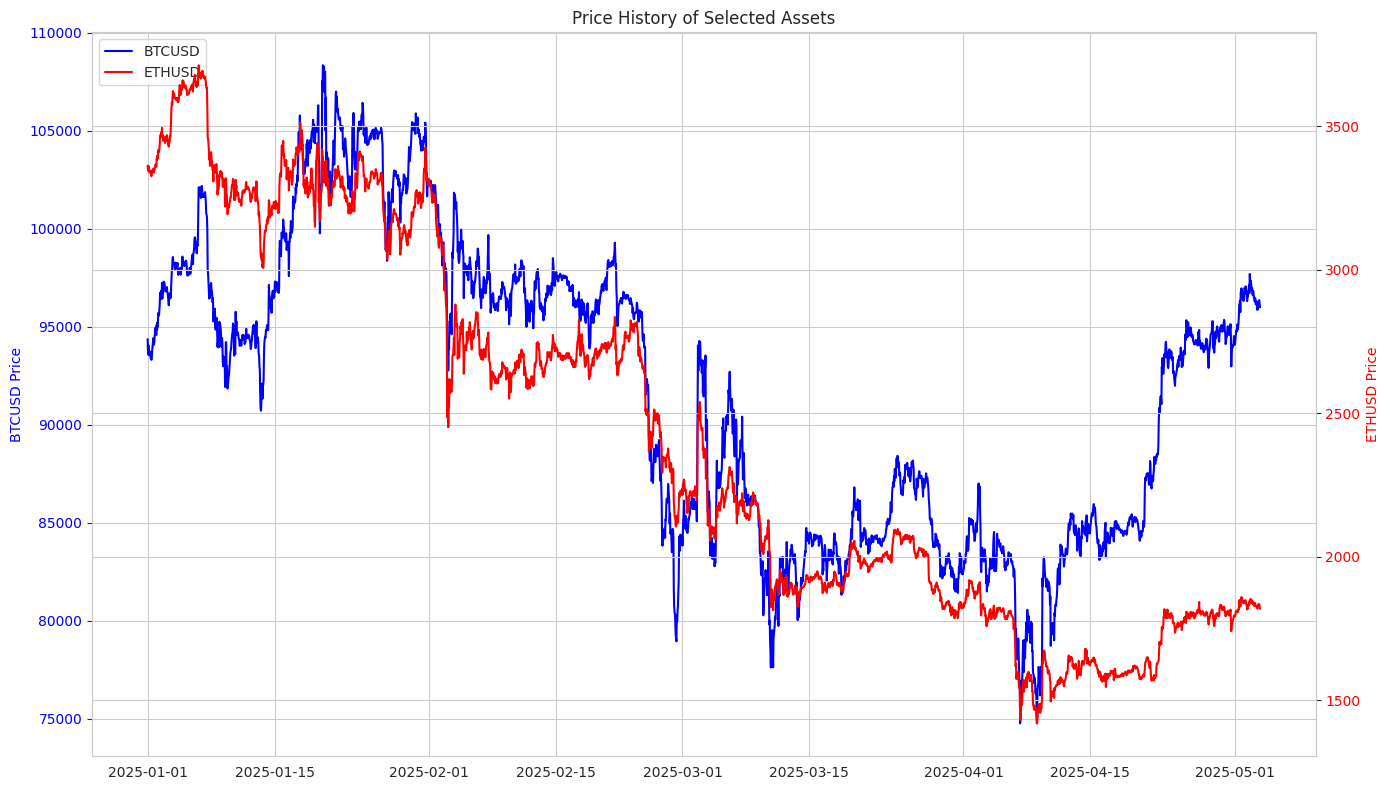

In [ ]:
def fetch_and_prepare_data():
    """
    Fetch historical data for the selected assets and prepare it for analysis.

    Returns:
        tuple: A tuple containing DataFrames for Asset A, Asset B, and the merged data.
    """
    # Get the selected configuration
    selected_config = get_ticker_config()

    print(f"Fetching historical data for {selected_config['asset_a']['symbol']} and {selected_config['asset_b']['symbol']}...")

    # Fetch historical data for Asset A
    asset_a_data = get_historical_candles(
        selected_config['asset_a']['id'],
        selected_config['timeframe'],
        selected_config['start_timestamp'],
        selected_config['end_timestamp']
    )

    # Fetch historical data for Asset B
    asset_b_data = get_historical_candles(
        selected_config['asset_b']['id'],
        selected_config['timeframe'],
        selected_config['start_timestamp'],
        selected_config['end_timestamp']
    )

    if asset_a_data.empty or asset_b_data.empty:
        print("Error: Failed to fetch data for one or both assets")
        return None, None, None

    print(f"Successfully fetched data:")
    print(f"Asset A ({selected_config['asset_a']['symbol']}): {len(asset_a_data)} candles")
    print(f"Asset B ({selected_config['asset_b']['symbol']}): {len(asset_b_data)} candles")

    # Add asset identifiers
    asset_a_data['symbol'] = selected_config['asset_a']['symbol']
    asset_b_data['symbol'] = selected_config['asset_b']['symbol']

    # Calculate log prices
    asset_a_data['log_price'] = np.log(asset_a_data['close'])
    asset_b_data['log_price'] = np.log(asset_b_data['close'])

    # Merge the data on timestamp
    asset_a_data_subset = asset_a_data[['close', 'log_price', 'symbol']].copy()
    asset_b_data_subset = asset_b_data[['close', 'log_price', 'symbol']].copy()

    asset_a_data_subset.columns = ['close_a', 'log_price_a', 'symbol_a']
    asset_b_data_subset.columns = ['close_b', 'log_price_b', 'symbol_b']

    # Reset index to merge on timestamp
    asset_a_data_subset = asset_a_data_subset.reset_index()
    asset_b_data_subset = asset_b_data_subset.reset_index()

    # Merge the data
    merged_data = pd.merge(asset_a_data_subset, asset_b_data_subset, on='timestamp', how='inner')
    merged_data = merged_data.set_index('timestamp')

    print(f"Merged data: {len(merged_data)} rows")

    return asset_a_data, asset_b_data, merged_data

# Fetch and prepare the data
asset_a_data, asset_b_data, merged_data = fetch_and_prepare_data()

# Display the first few rows of the merged data
if merged_data is not None:
    display(merged_data.tail())

    # Plot the price data
    plt.figure(figsize=(14, 8))

    # Create two y-axes
    ax1 = plt.gca()
    ax2 = ax1.twinx()

    # Plot Asset A on the left y-axis
    ax1.plot(merged_data.index, merged_data['close_a'], 'b-', label=merged_data['symbol_a'].iloc[0])
    ax1.set_ylabel(f"{merged_data['symbol_a'].iloc[0]} Price", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot Asset B on the right y-axis
    ax2.plot(merged_data.index, merged_data['close_b'], 'r-', label=merged_data['symbol_b'].iloc[0])
    ax2.set_ylabel(f"{merged_data['symbol_b'].iloc[0]} Price", color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Price History of Selected Assets')
    plt.grid(True)

    # Create a combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()

## 4. Statistical Arbitrage Algorithm Implementation

Now, let's implement the core statistical arbitrage algorithm, including hedge ratio calculation, spread calculation, and Z-score calculation.

Processed data with hedge ratio and Z-score:


,close_a,log_price_a,symbol_a,close_b,log_price_b,symbol_b,hedge_ratio,spread,spread_ma,spread_std,zscore
timestamp,,,,,,,,,,,
2025-05-03 13:00:00,96288.0,11.475099,BTCUSD,1834.45,7.514500,ETHUSD,0.802645,5.443625,9.034257,1.031325,-3.481573
2025-05-03 14:00:00,96314.5,11.475374,BTCUSD,1834.50,7.514527,ETHUSD,0.805302,5.423907,9.029972,1.039884,-3.467758
2025-05-03 15:00:00,96359.0,11.475836,BTCUSD,1833.95,7.514227,ETHUSD,0.807469,5.408329,9.025668,1.048428,-3.450248
2025-05-03 16:00:00,96150.5,11.473670,BTCUSD,1826.55,7.510184,ETHUSD,0.810140,5.389370,9.021342,1.056974,-3.436196
2025-05-03 17:00:00,95987.0,11.471968,BTCUSD,1818.45,7.505740,ETHUSD,0.812605,5.372768,9.016996,1.065512,-3.420168


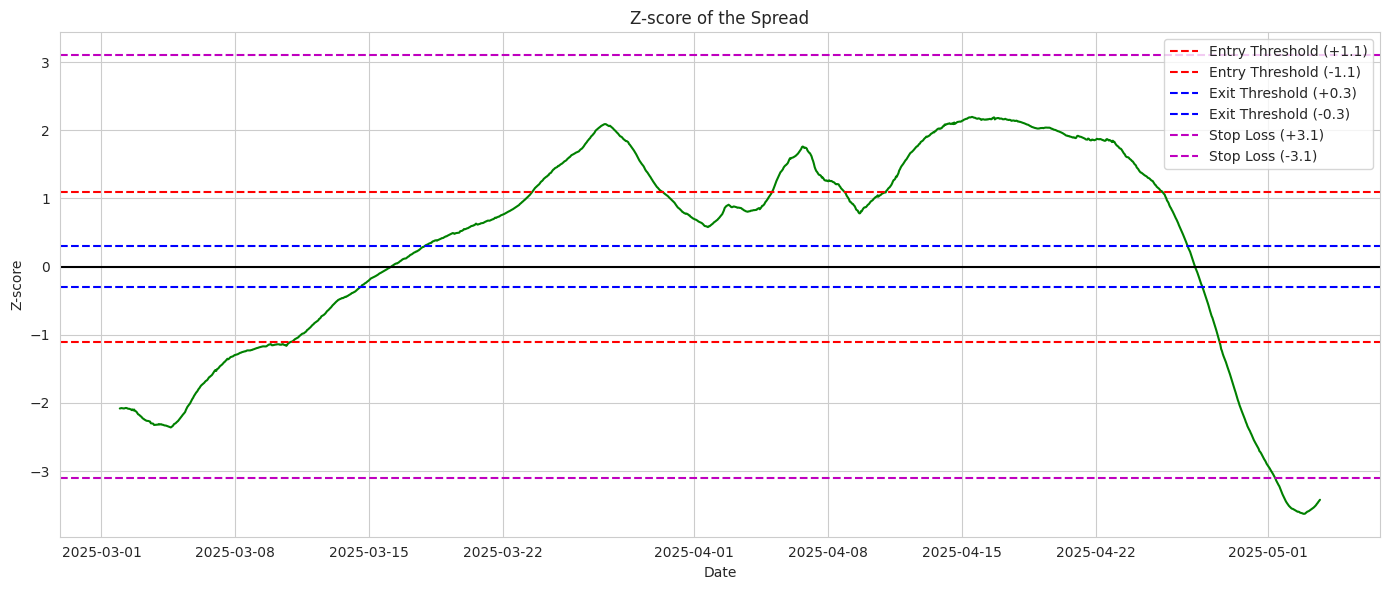


Trade Quantity Calculation Example:
Primary Asset: BTCUSD at price 95987.00
Secondary Asset: ETHUSD at price 1818.45
Hedge Ratio (β): 0.8126
Primary Quantity: 1.0
Calculated Secondary Quantity: 42.8934
Current Z-score: -3.4202


In [ ]:
def calculate_hedge_ratio(merged_data, lookback_period=30):
    """
    Calculate the hedge ratio (β) using OLS regression.

    Args:
        merged_data (DataFrame): The merged price data for both assets.
        lookback_period (int): The lookback period in days for the regression.

    Returns:
        DataFrame: The input DataFrame with hedge ratio and spread columns added.
    """
    # Convert lookback period from days to number of data points
    # This depends on the timeframe of the data
    timeframe = get_ticker_config()['timeframe']
    points_per_day = {
        '1m': 24 * 60,
        '5m': 24 * 12,
        '15m': 24 * 4,
        '30m': 24 * 2,
        '1h': 24,
        '2h': 12,
        '4h': 6,
        '6h': 4,
        '12h': 2,
        '1d': 1,
        '1w': 1/7
    }

    lookback_points = int(lookback_period * points_per_day.get(timeframe, 24))

    # Create a copy of the data to avoid modifying the original
    data = merged_data.copy()

    # Initialize columns for hedge ratio and spread
    data['hedge_ratio'] = np.nan
    data['spread'] = np.nan

    # Calculate rolling hedge ratio using OLS regression
    for i in range(lookback_points, len(data)):
        # Get the data for the lookback period
        y = data['log_price_a'].iloc[i-lookback_points:i]
        X = data['log_price_b'].iloc[i-lookback_points:i]
        X = sm.add_constant(X)  # Add a constant term to the predictor

        # Fit the OLS model
        model = sm.OLS(y, X).fit()

        # Extract the hedge ratio (β)
        beta = model.params[1]

        # Store the hedge ratio
        data['hedge_ratio'].iloc[i] = beta

        # Calculate the spread
        data['spread'].iloc[i] = data['log_price_a'].iloc[i] - beta * data['log_price_b'].iloc[i]

    return data

def calculate_zscore(data, lookback_period=30):
    """
    Calculate the Z-score of the spread.

    Args:
        data (DataFrame): The data with hedge ratio and spread columns.
        lookback_period (int): The lookback period in days for the moving average and standard deviation.

    Returns:
        DataFrame: The input DataFrame with Z-score column added.
    """
    # Convert lookback period from days to number of data points
    timeframe = get_ticker_config()['timeframe']
    points_per_day = {
        '1m': 24 * 60,
        '5m': 24 * 12,
        '15m': 24 * 4,
        '30m': 24 * 2,
        '1h': 24,
        '2h': 12,
        '4h': 6,
        '6h': 4,
        '12h': 2,
        '1d': 1,
        '1w': 1/7
    }

    lookback_points = int(lookback_period * points_per_day.get(timeframe, 24))

    # Create a copy of the data to avoid modifying the original
    result = data.copy()

    # Calculate the moving average and standard deviation of the spread
    result['spread_ma'] = result['spread'].rolling(window=lookback_points).mean()
    result['spread_std'] = result['spread'].rolling(window=lookback_points).std()

    # Calculate the Z-score
    result['zscore'] = (result['spread'] - result['spread_ma']) / result['spread_std']

    return result

def calculate_secondary_quantity(primary_quantity, hedge_ratio, primary_price, secondary_price, primary_is_asset_a):
    """
    Calculate the quantity of the secondary asset based on the hedge ratio.

    Args:
        primary_quantity (float): The quantity of the primary asset.
        hedge_ratio (float): The hedge ratio (β).
        primary_price (float): The price of the primary asset.
        secondary_price (float): The price of the secondary asset.
        primary_is_asset_a (bool): True if the primary asset is Asset A, False if it's Asset B.

    Returns:
        float: The quantity of the secondary asset.
    """
    # Calculate the notional value of the primary position
    primary_notional = primary_quantity * primary_price

    # Calculate the hedge ratio based on which asset is primary
    if primary_is_asset_a:
        # If primary is Asset A, use the hedge ratio directly
        effective_hedge_ratio = hedge_ratio
    else:
        # If primary is Asset B, use the inverse of the hedge ratio
        effective_hedge_ratio = 1 / hedge_ratio if hedge_ratio != 0 else 0

    # Calculate the notional value of the secondary position
    secondary_notional = primary_notional * effective_hedge_ratio

    # Calculate the quantity of the secondary asset
    secondary_quantity = secondary_notional / secondary_price

    return secondary_quantity

# Process the data with the statistical arbitrage algorithm
if merged_data is not None:
    # Get the lookback period from the configuration
    lookback_period = config['lookback_period']

    # Calculate hedge ratio and spread
    data_with_hedge_ratio = calculate_hedge_ratio(merged_data, lookback_period)

    # Calculate Z-score
    data_with_zscore = calculate_zscore(data_with_hedge_ratio, lookback_period)

    # Display the processed data
    print("Processed data with hedge ratio and Z-score:")
    display(data_with_zscore.tail())

    # Plot the Z-score
    plt.figure(figsize=(14, 6))
    plt.plot(data_with_zscore.index, data_with_zscore['zscore'], 'g-')
    plt.axhline(y=config['entry_threshold'], color='r', linestyle='--', label=f"Entry Threshold (+{config['entry_threshold']})")
    plt.axhline(y=-config['entry_threshold'], color='r', linestyle='--', label=f"Entry Threshold (-{config['entry_threshold']})")
    plt.axhline(y=config['exit_threshold'], color='b', linestyle='--', label=f"Exit Threshold (+{config['exit_threshold']})")
    plt.axhline(y=-config['exit_threshold'], color='b', linestyle='--', label=f"Exit Threshold (-{config['exit_threshold']})")
    plt.axhline(y=config['stop_loss_threshold'], color='m', linestyle='--', label=f"Stop Loss (+{config['stop_loss_threshold']})")
    plt.axhline(y=-config['stop_loss_threshold'], color='m', linestyle='--', label=f"Stop Loss (-{config['stop_loss_threshold']})")
    plt.axhline(y=0, color='k', linestyle='-')
    plt.title('Z-score of the Spread')
    plt.xlabel('Date')
    plt.ylabel('Z-score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Calculate and display an example of secondary quantity calculation
    selected_config = get_ticker_config()
    primary_is_asset_a = selected_config['primary_asset']['id'] == selected_config['asset_a']['id']

    # Get the latest data point
    latest_data = data_with_zscore.dropna().iloc[-1]

    # Get prices and hedge ratio
    price_a = latest_data['close_a']
    price_b = latest_data['close_b']
    hedge_ratio = latest_data['hedge_ratio']

    # Get primary quantity from user input
    primary_quantity = selected_config['quantity']

    # Calculate secondary quantity
    if primary_is_asset_a:
        primary_price = price_a
        secondary_price = price_b
    else:
        primary_price = price_b
        secondary_price = price_a

    secondary_quantity = calculate_secondary_quantity(
        primary_quantity,
        hedge_ratio,
        primary_price,
        secondary_price,
        primary_is_asset_a
    )

    print(f"\nTrade Quantity Calculation Example:")
    print(f"Primary Asset: {selected_config['primary_asset']['symbol']} at price {primary_price:.2f}")
    print(f"Secondary Asset: {selected_config['secondary_asset']['symbol']} at price {secondary_price:.2f}")
    print(f"Hedge Ratio (β): {hedge_ratio:.4f}")
    print(f"Primary Quantity: {primary_quantity}")
    print(f"Calculated Secondary Quantity: {secondary_quantity:.4f}")
    print(f"Current Z-score: {latest_data['zscore']:.4f}")